# Supply Chain Cost Analysis & ML Prediction

## Objective
This notebook demonstrates a supply chain cost scenario. We will:
1. **Simulate a dataset** representing daily operations across multiple distribution centers.
2. **Visualize cost drivers** and trends over time.
3. **Propose and implement a Machine Learning model** to predict future total costs based on operational metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Scenario Simulation

We maintain 3 regional warehouses (North, South, Central). We need to track:
- **Demand**: Daily units requested.
- **Transport Cost**: Cost to move goods (fluctuates with fuel prices).
- **Inventory Levels**: Current stock.
- **Lead Time**: Days to restock.

We will generate synthetic data for the past 365 days.

In [2]:
np.random.seed(42)

# Parameters
days = 365
warehouses = ['North_DC', 'South_DC', 'Central_DC']
dates = pd.date_range(start='2023-01-01', periods=days)

data = []

for wh in warehouses:
    # Generate base trends with some random noise
    demand = np.random.normal(loc=1000, scale=200, size=days).astype(int)
    
    # Seasonality effect (higher in Q4)
    seasonality = np.linspace(1, 1.5, days)
    demand = (demand * seasonality).astype(int)

    # Operational metrics
    transport_cost_per_unit = np.random.uniform(2.5, 4.0, size=days) # Fluctuating fuel/carrier rates
    lead_time = np.random.poisson(lam=3, size=days) # Average 3 days lead time
    inventory_level = np.random.randint(500, 3000, size=days)
    
    # Calculate costs
    # Holding cost assumed $0.5 per unit per day
    holding_cost = inventory_level * 0.5
    
    # Transport cost calculation
    total_transport_cost = demand * transport_cost_per_unit
    
    # Total Operational Cost
    total_cost = total_transport_cost + holding_cost + (lead_time * 100) # Penalty for long lead times

    # Create DataFrame segment
    df_segment = pd.DataFrame({
        'Date': dates,
        'Warehouse': wh,
        'Demand': demand,
        'Transport_Unit_Cost': transport_cost_per_unit,
        'Inventory_Level': inventory_level,
        'Lead_Time_Days': lead_time,
        'Total_Transport_Cost': total_transport_cost,
        'Holding_Cost': holding_cost,
        'Total_Cost': total_cost
    })
    data.append(df_segment)

df = pd.concat(data).reset_index(drop=True)
df.head()

,Date,Warehouse,Demand,Transport_Unit_Cost,Inventory_Level,Lead_Time_Days,Total_Transport_Cost,Holding_Cost,Total_Cost
0,2023-01-01,North_DC,1099,2.835394,940,2,3116.097740,470.0,3786.097740
1,2023-01-02,North_DC,973,3.944834,2640,4,3838.323296,1320.0,5558.323296
2,2023-01-03,North_DC,1132,2.518232,2144,3,2850.638298,1072.0,4222.638298
3,2023-01-04,North_DC,1309,3.954818,1366,1,5176.857076,683.0,5959.857076
4,2023-01-05,North_DC,958,2.564740,1947,3,2457.020793,973.5,3730.520793


## 2. Visualization & Analysis

Let's explore the cost drivers and trends.

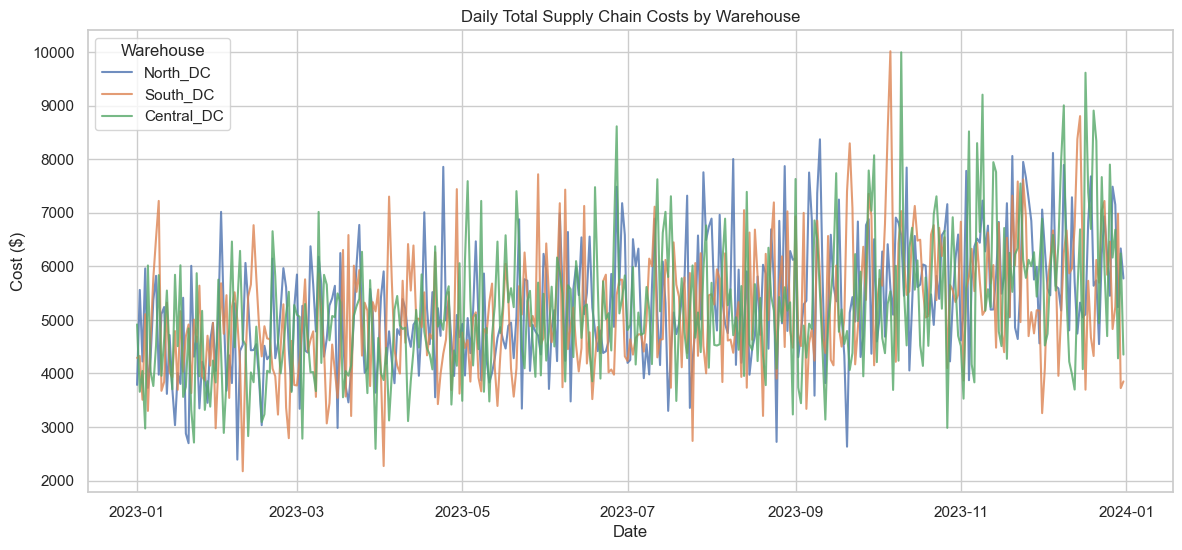

In [3]:
# 1. Total Cost Trend Over Time by Warehouse
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Date', y='Total_Cost', hue='Warehouse', alpha=0.8)
plt.title('Daily Total Supply Chain Costs by Warehouse')
plt.ylabel('Cost ($)')
plt.show()

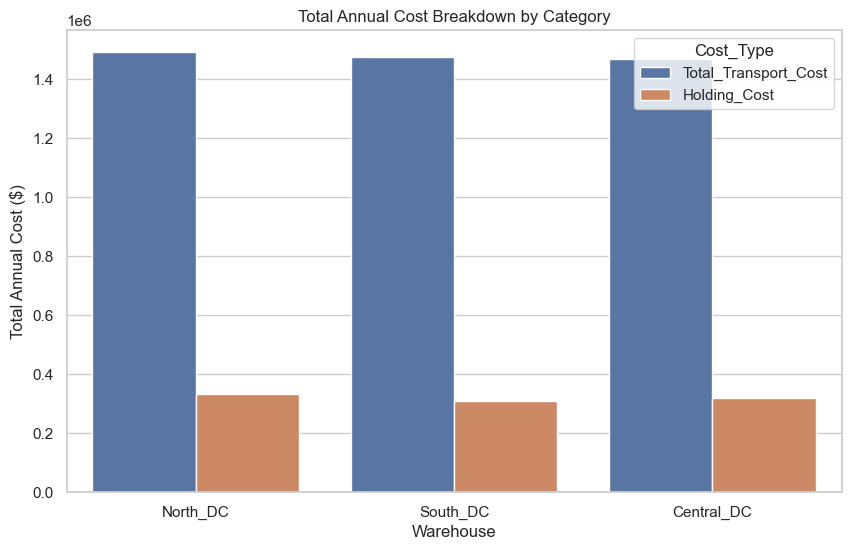

In [4]:
# 2. Cost Distribution Breakdown
cost_cols = ['Total_Transport_Cost', 'Holding_Cost']
df_melted = df.melt(id_vars=['Date', 'Warehouse'], value_vars=cost_cols, var_name='Cost_Type', value_name='Amount')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Warehouse', y='Amount', hue='Cost_Type', estimator=np.sum, errorbar=None)
plt.title('Total Annual Cost Breakdown by Category')
plt.ylabel('Total Annual Cost ($)')
plt.show()

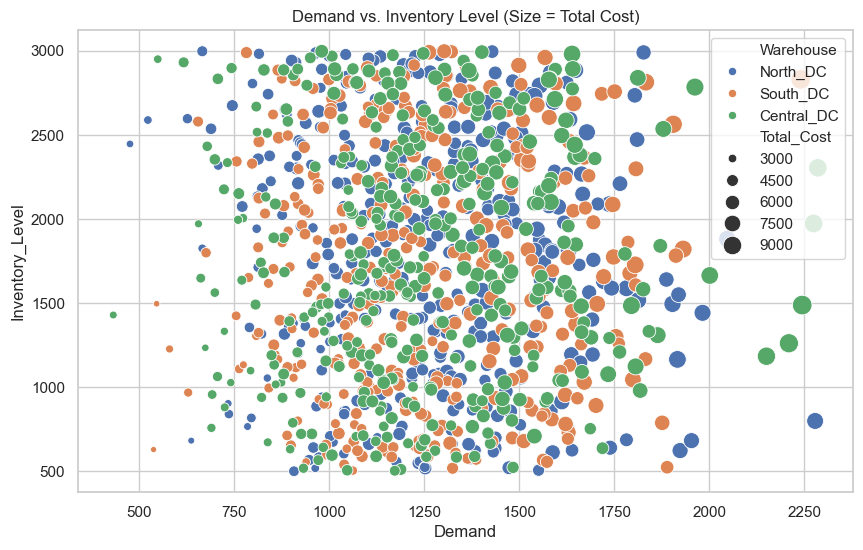

In [5]:
# 3. Demand vs. Inventory Scatter
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Demand', y='Inventory_Level', hue='Warehouse', size='Total_Cost', sizes=(20, 200))
plt.title('Demand vs. Inventory Level (Size = Total Cost)')
plt.show()

## 3. Machine Learning Proposal

### Objective
We want to build a model to **predict next-day Total Cost**. 
This allows finance and operations teams to better allocate daily budgets and anticipate spikes in spending.

### Approach
- **Target Variable**: `Total_Cost`
- **Features**:
    - `Demand` (Projected)
    - `Inventory_Level` (Current)
    - `Lead_Time_Days` (Estimated)
    - `Transport_Unit_Cost` (Market Index)
    - `Month` (Seasonality)
    - `Warehouse` (Categorical)

### Model Selection
We will use a **Random Forest Regressor** due to its ability to handle non-linear relationships and interactions between variables (e.g., high demand + high transport cost = exponential total cost).

In [6]:
# Prepare features
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Encoding categorical variables
df_ml = pd.get_dummies(df, columns=['Warehouse'], drop_first=True)

# Feature selection
features = ['Demand', 'Inventory_Level', 'Transport_Unit_Cost', 'Lead_Time_Days', 'Month', 'DayOfWeek'] + [col for col in df_ml.columns if 'Warehouse_' in col]
target = 'Total_Cost'

X = df_ml[features]
y = df_ml[target]

# Train/Test Split (Time-based split is often better for TS, but random split is fine for this simulated snapshot)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Average Cost in Test Set: ${y_test.mean():.2f}")

Model Performance:
MAE: $167.86
RMSE: $236.38
Average Cost in Test Set: $5286.35


C:\Users\User\AppData\Local\Temp\ipykernel_2632\1522372086.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')


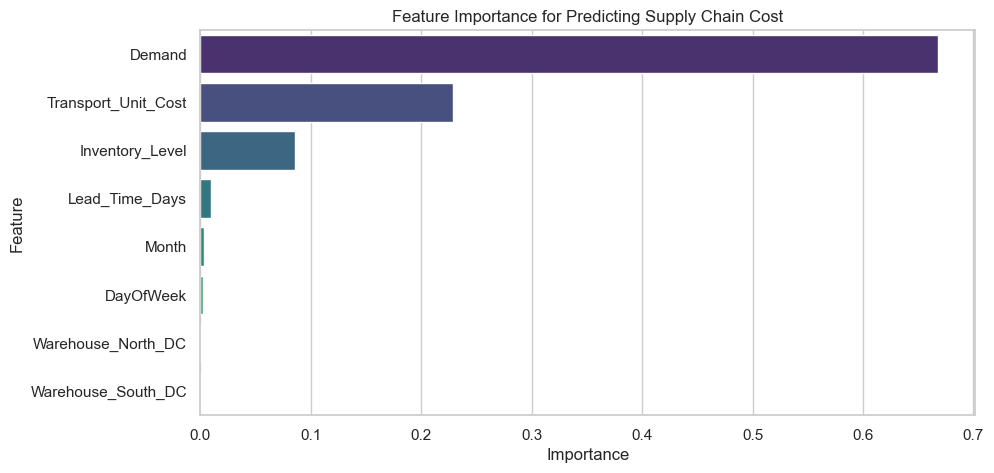

In [7]:
# Feature Importance Visualization
importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Predicting Supply Chain Cost')
plt.show()

### Conclusion & Next Steps
- **Demand** is the strongest driver of cost in this simulation, followed by transport unit rates.
- The model predicts costs with reasonable accuracy.
- **Next Steps**:
    - Deploy model to warn managers when predicted costs exceed budget thresholds.
    - Run "What-If" scenarios (e.g., "If we reduce Lead Time by 1 day, how much do we save?").